In [ ]:
# Install the required libraries.
!pip install pafy youtube-dl moviepy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 14.2 MB/s eta 0:00:00


In [ ]:
import os
import cv2
import pafy
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt

from moviepy.editor import *
%matplotlib inline

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

  if event.key is 'enter':



In [ ]:
seed_constant = 27
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

In [ ]:
# Discard the output of this cell.
%%capture

# Downlaod the UCF50 Dataset
!wget --no-check-certificate https://www.crcv.ucf.edu/data/UCF50.rar

#Extract the Dataset
!unrar x UCF50.rar

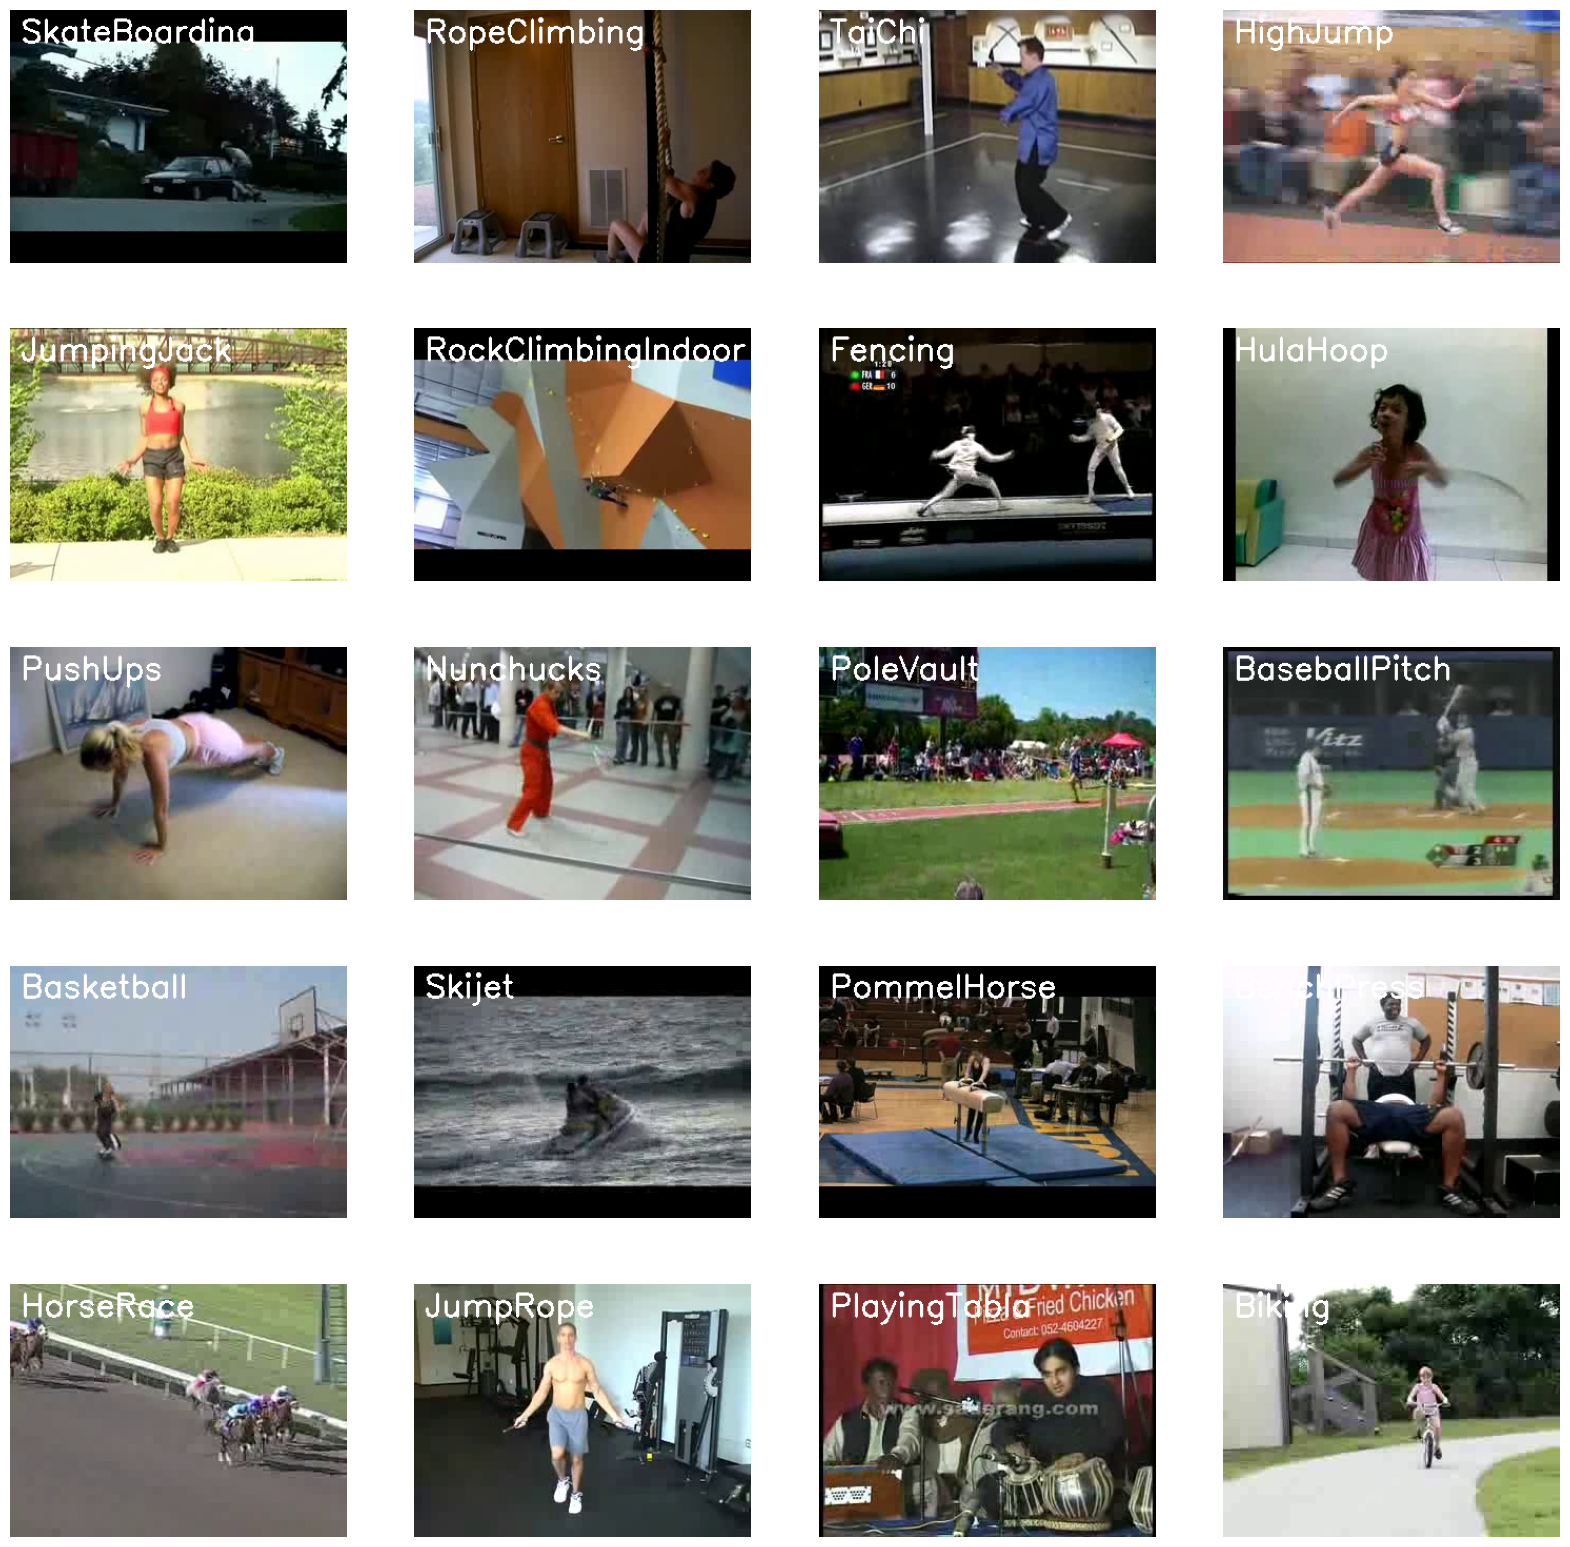

In [ ]:
# Create a Matplotlib figure and specify the size of the figure.
plt.figure(figsize = (20, 20))

# Get the names of all classes/categories in UCF50.
all_classes_names = os.listdir('UCF50')

# Generate a list of 20 random values. The values will be between 0-50,
# where 50 is the total number of class in the dataset.
random_range = random.sample(range(len(all_classes_names)), 20)

# Iterating through all the generated random values.
for counter, random_index in enumerate(random_range, 1):

    # Retrieve a Class Name using the Random Index.
    selected_class_Name = all_classes_names[random_index]

    # Retrieve the list of all the video files present in the randomly selected Class Directory.
    video_files_names_list = os.listdir(f'UCF50/{selected_class_Name}')

    # Randomly select a video file from the list retrieved from the randomly selected Class Directory.
    selected_video_file_name = random.choice(video_files_names_list)

    # Initialize a VideoCapture object to read from the video File.
    video_reader = cv2.VideoCapture(f'UCF50/{selected_class_Name}/{selected_video_file_name}')

    # Read the first frame of the video file.
    _, bgr_frame = video_reader.read()

    # Release the VideoCapture object.
    video_reader.release()

    # Convert the frame from BGR into RGB format.
    rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)

    # Write the class name on the video frame.
    cv2.putText(rgb_frame, selected_class_Name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

    # Display the frame.
    plt.subplot(5, 4, counter);plt.imshow(rgb_frame);plt.axis('off')

In [ ]:
# Specify the height and width to which each video frame will be resized in our dataset.
IMAGE_HEIGHT , IMAGE_WIDTH = 64, 64

# Specify the number of frames of a video that will be fed to the model as one sequence.
SEQUENCE_LENGTH = 20

# Specify the directory containing the UCF50 dataset.
DATASET_DIR = "UCF50"

# Specify the list containing the names of the classes used for training. Feel free to choose any set of classes.
CLASSES_LIST = ["WalkingWithDog", "TaiChi", "Swing", "HorseRace","JumpingJack","PlayingGuitar"]

In [ ]:
def frames_extraction(video_path):
    '''
    This function will extract the required frames from a video after resizing and normalizing them.
    Args:
        video_path: The path of the video in the disk, whose frames are to be extracted.
    Returns:
        frames_list: A list containing the resized and normalized frames of the video.
    '''

    # Declare a list to store video frames.
    frames_list = []

    # Read the Video File using the VideoCapture object.
    video_reader = cv2.VideoCapture(video_path)

    # Get the total number of frames in the video.
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    # Calculate the the interval after which frames will be added to the list.
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)

    # Iterate through the Video Frames.
    for frame_counter in range(SEQUENCE_LENGTH):

        # Set the current frame position of the video.
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

        # Reading the frame from the video.
        success, frame = video_reader.read()

        # Check if Video frame is not successfully read then break the loop
        if not success:
            break

        # Resize the Frame to fixed height and width.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))

        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1
        normalized_frame = resized_frame / 255

        # Append the normalized frame into the frames list
        frames_list.append(normalized_frame)

    # Release the VideoCapture object.
    video_reader.release()

    # Return the frames list.
    return frames_list

In [ ]:
def create_dataset():
    '''
    This function will extract the data of the selected classes and create the required dataset.
    Returns:
        features:          A list containing the extracted frames of the videos.
        labels:            A list containing the indexes of the classes associated with the videos.
        video_files_paths: A list containing the paths of the videos in the disk.
    '''

    # Declared Empty Lists to store the features, labels and video file path values.
    features = []
    labels = []
    video_files_paths = []

    # Iterating through all the classes mentioned in the classes list
    for class_index, class_name in enumerate(CLASSES_LIST):

        # Display the name of the class whose data is being extracted.
        print(f'Extracting Data of Class: {class_name}')

        # Get the list of video files present in the specific class name directory.
        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))

        # Iterate through all the files present in the files list.
        for file_name in files_list:

            # Get the complete video path.
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)

            # Extract the frames of the video file.
            frames = frames_extraction(video_file_path)

            # Check if the extracted frames are equal to the SEQUENCE_LENGTH specified above.
            # So ignore the vides having frames less than the SEQUENCE_LENGTH.
            if len(frames) == SEQUENCE_LENGTH:

                # Append the data to their repective lists.
                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)

    # Converting the list to numpy arrays
    features = np.asarray(features)
    labels = np.array(labels)

    # Return the frames, class index, and video file path.
    return features, labels, video_files_paths

In [ ]:
# Create the dataset.
features, labels, video_files_paths = create_dataset()

Extracting Data of Class: WalkingWithDog
Extracting Data of Class: TaiChi
Extracting Data of Class: Swing
Extracting Data of Class: HorseRace
Extracting Data of Class: JumpingJack
Extracting Data of Class: PlayingGuitar


In [ ]:
# Using Keras's to_categorical method to convert labels into one-hot-encoded vectors
one_hot_encoded_labels = to_categorical(labels)

In [ ]:
# Split the Data into Train ( 75% ) and Test Set ( 25% ).
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels, test_size = 0.25, shuffle = True, random_state = seed_constant)

In [ ]:
def create_convlstm_model():
    '''
    This function will construct the required convlstm model.
    Returns:
        model: It is the required constructed convlstm model.
    '''

    # We will use a Sequential model for model construction
    model = Sequential()

    # Define the Model Architecture.
    ########################################################################################################################

    model.add(ConvLSTM2D(filters = 4, kernel_size = (3, 3), activation = 'tanh',data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True, input_shape = (SEQUENCE_LENGTH,
                                                                                      IMAGE_HEIGHT, IMAGE_WIDTH, 3)))

    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))

    model.add(ConvLSTM2D(filters = 8, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))

    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))

    model.add(ConvLSTM2D(filters = 14, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))

    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))

    model.add(ConvLSTM2D(filters = 16, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))

    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    #model.add(TimeDistributed(Dropout(0.2)))

    model.add(Flatten())

    model.add(Dense(len(CLASSES_LIST), activation = "softmax"))

    ########################################################################################################################

    # Display the models summary.
    model.summary()

    # Return the constructed convlstm model.
    return model

In [ ]:
# Construct the required convlstm model.
convlstm_model = create_convlstm_model()

# Display the success message.
print("Model Created Successfully!")


  super().__init__(**kwargs)



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_lstm2d (ConvLSTM2D)        │ (None, 20, 62, 62, 4)  │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 20, 31, 31, 4)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 20, 31, 31, 4)  │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_1 (ConvLSTM2D)      │ (None, 20, 29, 29, 8)  │         3,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_1 (MaxPooling3D)  │ (None, 20, 15, 15, 8)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 20, 15, 15, 8)  │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_2 (ConvLSTM2D)      │ (None, 20, 13, 13, 14) │        11,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_2 (MaxPooling3D)  │ (None, 20, 7, 7, 14)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 20, 7, 7, 14)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_3 (ConvLSTM2D)      │ (None, 20, 5, 5, 16)   │        17,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_3 (MaxPooling3D)  │ (None, 20, 3, 3, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2880)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 6)              │        17,286 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,286 (196.43 KB)

 Trainable params: 50,286 (196.43 KB)

 Non-trainable params: 0 (0.00 B)

Model Created Successfully!


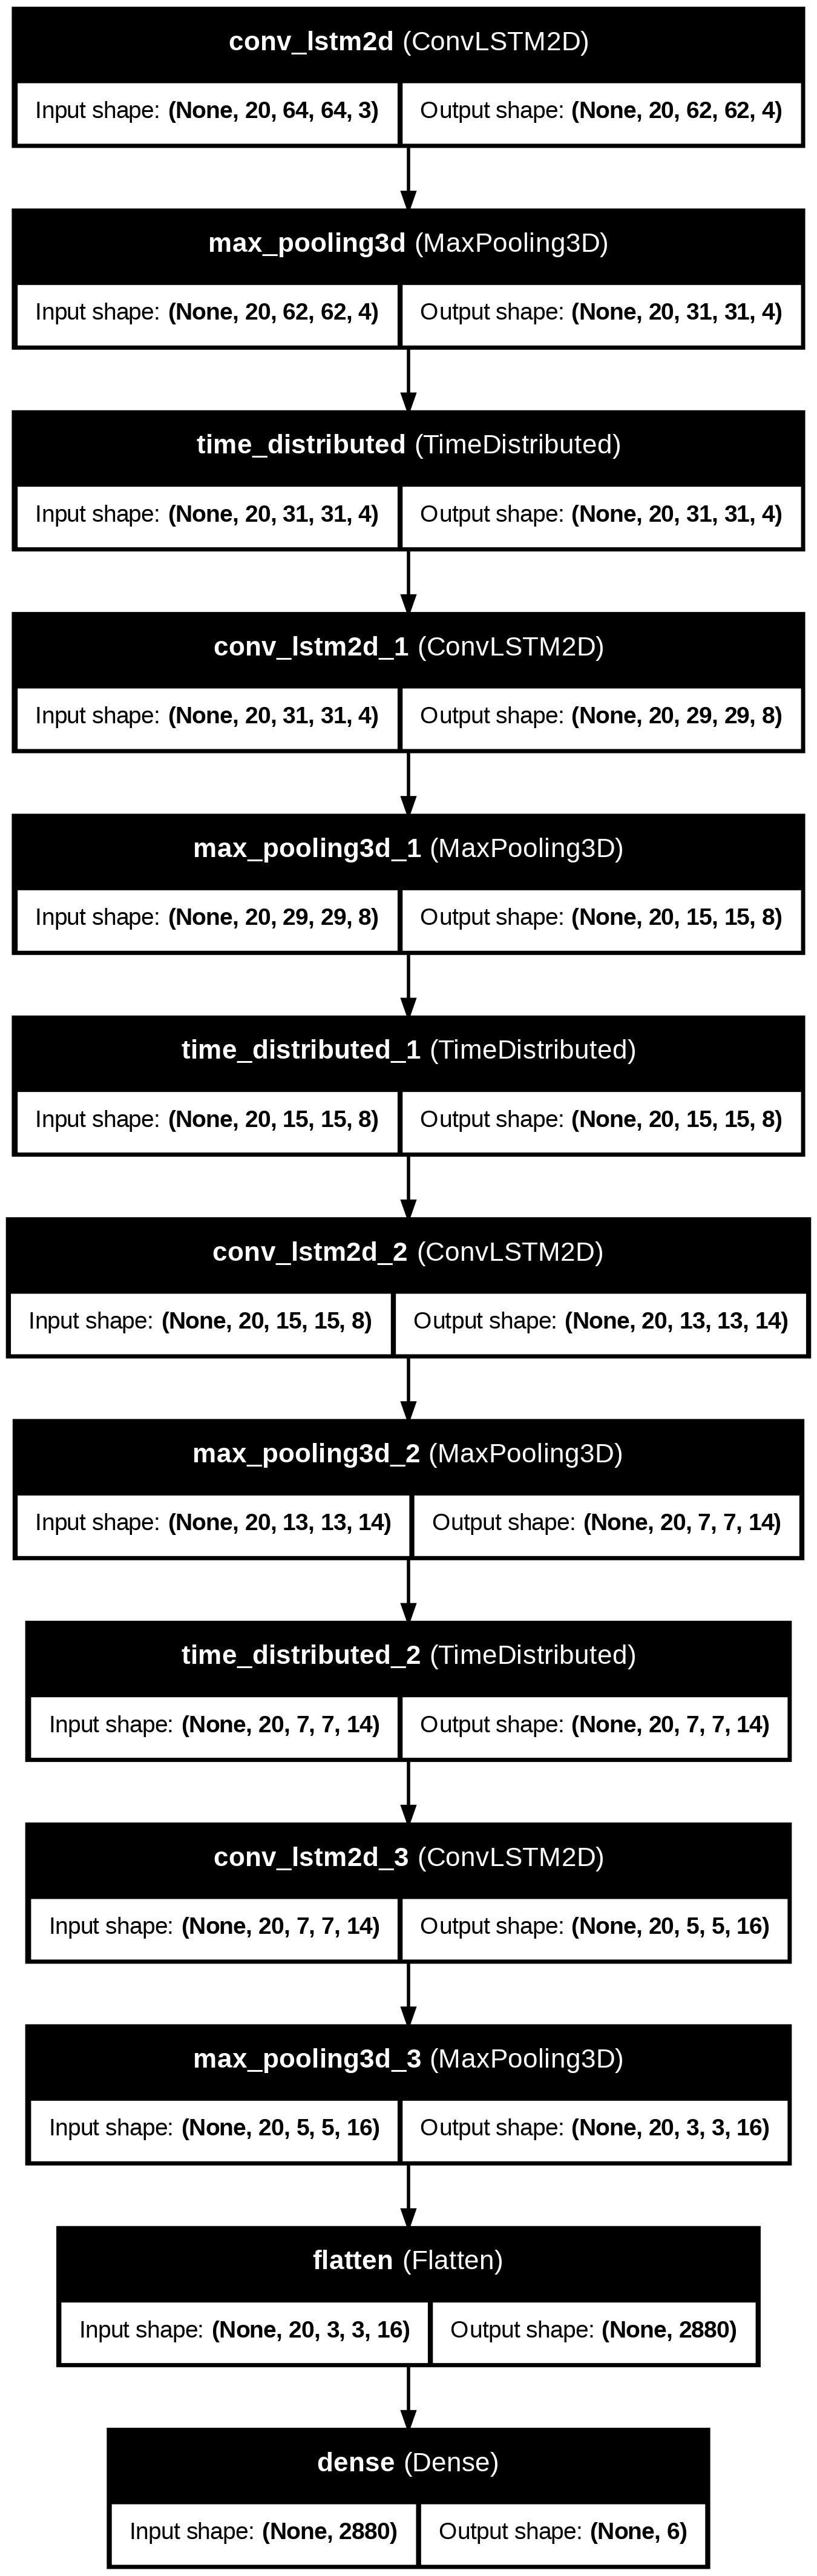

In [ ]:
# Plot the structure of the contructed model.
plot_model(convlstm_model, to_file = 'convlstm_model_structure_plot.png', show_shapes = True, show_layer_names = True)


In [ ]:
# Create an Instance of Early Stopping Callback
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 10, mode = 'min', restore_best_weights = True)

# Compile the model and specify loss function, optimizer and metrics values to the model
convlstm_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

# Start training the model.
convlstm_model_training_history = convlstm_model.fit(x = features_train, y = labels_train, epochs = 50, batch_size = 4,shuffle = True, validation_split = 0.2, callbacks = [early_stopping_callback])

Epoch 1/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 195s 2s/step - accuracy: 0.2277 - loss: 1.7949 - val_accuracy: 0.3190 - val_loss: 1.7526
Epoch 2/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 199s 1s/step - accuracy: 0.3056 - loss: 1.6634 - val_accuracy: 0.4138 - val_loss: 1.5206
Epoch 3/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 201s 1s/step - accuracy: 0.4634 - loss: 1.3326 - val_accuracy: 0.5345 - val_loss: 1.0891
Epoch 4/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 202s 1s/step - accuracy: 0.6131 - loss: 1.0284 - val_accuracy: 0.6034 - val_loss: 0.9765
Epoch 5/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 201s 1s/step - accuracy: 0.7305 - loss: 0.7374 - val_accuracy: 0.6552 - val_loss: 0.7793
Epoch 6/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 192s 1s/step - accuracy: 0.7628 - loss: 0.6114 - val_accuracy: 0.7759 - val_loss: 0.6731
Epoch 7/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 169s 1s/step - accuracy: 0.8136 - loss: 0.5187 - val_accuracy: 0.7759 - val_loss: 0.6009
Epoch 8/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 208s 2s/step - accuracy: 0.8429 - loss: 0.4160 - val_accu

In [ ]:
model_evaluation_history = convlstm_model.evaluate(features_test, labels_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 22s 3s/step - accuracy: 0.8386 - loss: 0.4865


In [ ]:
# Get the loss and accuracy from model_evaluation_history.
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history

# Define the string date format.
# Get the current Date and Time in a DateTime Object.
# Convert the DateTime object to string according to the style mentioned in date_time_format string.
date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)

# Define a useful name for our model to make it easy for us while navigating through multiple saved models.
model_file_name = f'convlstm_model___Date_Time_{current_date_time_string}___Loss_{model_evaluation_loss}___Accuracy_{model_evaluation_accuracy}.h5'

# Save your Model.
convlstm_model.save(model_file_name)

In [ ]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
    '''
    This function will plot the metrics passed to it in a graph.
    Args:
        model_training_history: A history object containing a record of training and validation
                                loss values and metrics values at successive epochs
        metric_name_1:          The name of the first metric that needs to be plotted in the graph.
        metric_name_2:          The name of the second metric that needs to be plotted in the graph.
        plot_name:              The title of the graph.
    '''

    # Get metric values using metric names as identifiers.
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]

    # Construct a range object which will be used as x-axis (horizontal plane) of the graph.
    epochs = range(len(metric_value_1))

    # Plot the Graph.
    plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
    plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)

    # Add title to the plot.
    plt.title(str(plot_name))

    # Add legend to the plot.
    plt.legend()

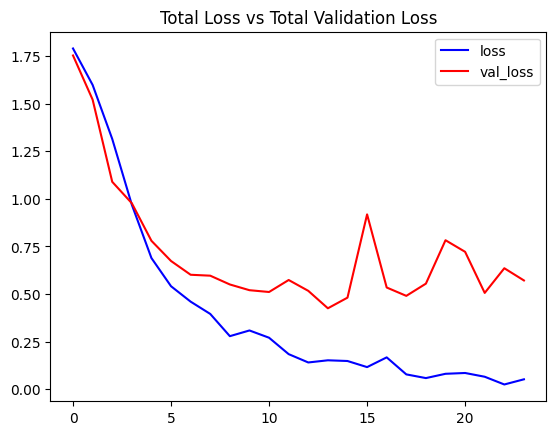

In [ ]:
# Visualize the training and validation loss metrices.
plot_metric(convlstm_model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

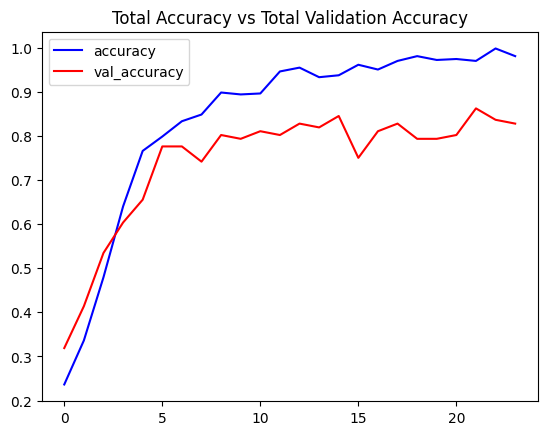

In [ ]:
plot_metric(convlstm_model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')

In [ ]:
def create_LRCN_model():
    '''
    This function will construct the required LRCN model.
    Returns:
        model: It is the required constructed LRCN model.
    '''

    # We will use a Sequential model for model construction.
    model = Sequential()

    # Define the Model Architecture.
    ########################################################################################################################

    model.add(TimeDistributed(Conv2D(16, (3, 3), padding='same',activation = 'relu'),
                              input_shape = (SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))

    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    #model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Flatten()))

    model.add(LSTM(32))

    model.add(Dense(len(CLASSES_LIST), activation = 'softmax'))

    ########################################################################################################################

    # Display the models summary.
    model.summary()

    # Return the constructed LRCN model.
    return model

In [ ]:
# Construct the required LRCN model.
LRCN_model = create_LRCN_model()

# Display the success message.
print("Model Created Successfully!")


  super().__init__(**kwargs)



Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_3              │ (None, 20, 64, 64, 16) │           448 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_4              │ (None, 20, 16, 16, 16) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_5              │ (None, 20, 16, 16, 16) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_6              │ (None, 20, 16, 16, 32) │         4,640 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_7              │ (None, 20, 4, 4, 32)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_8              │ (None, 20, 4, 4, 32)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_9              │ (None, 20, 4, 4, 64)   │        18,496 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_10             │ (None, 20, 2, 2, 64)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_11             │ (None, 20, 2, 2, 64)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_12             │ (None, 20, 2, 2, 64)   │        36,928 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_13             │ (None, 20, 1, 1, 64)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_14             │ (None, 20, 64)         │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           198 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 73,126 (285.65 KB)

 Trainable params: 73,126 (285.65 KB)

 Non-trainable params: 0 (0.00 B)

Model Created Successfully!


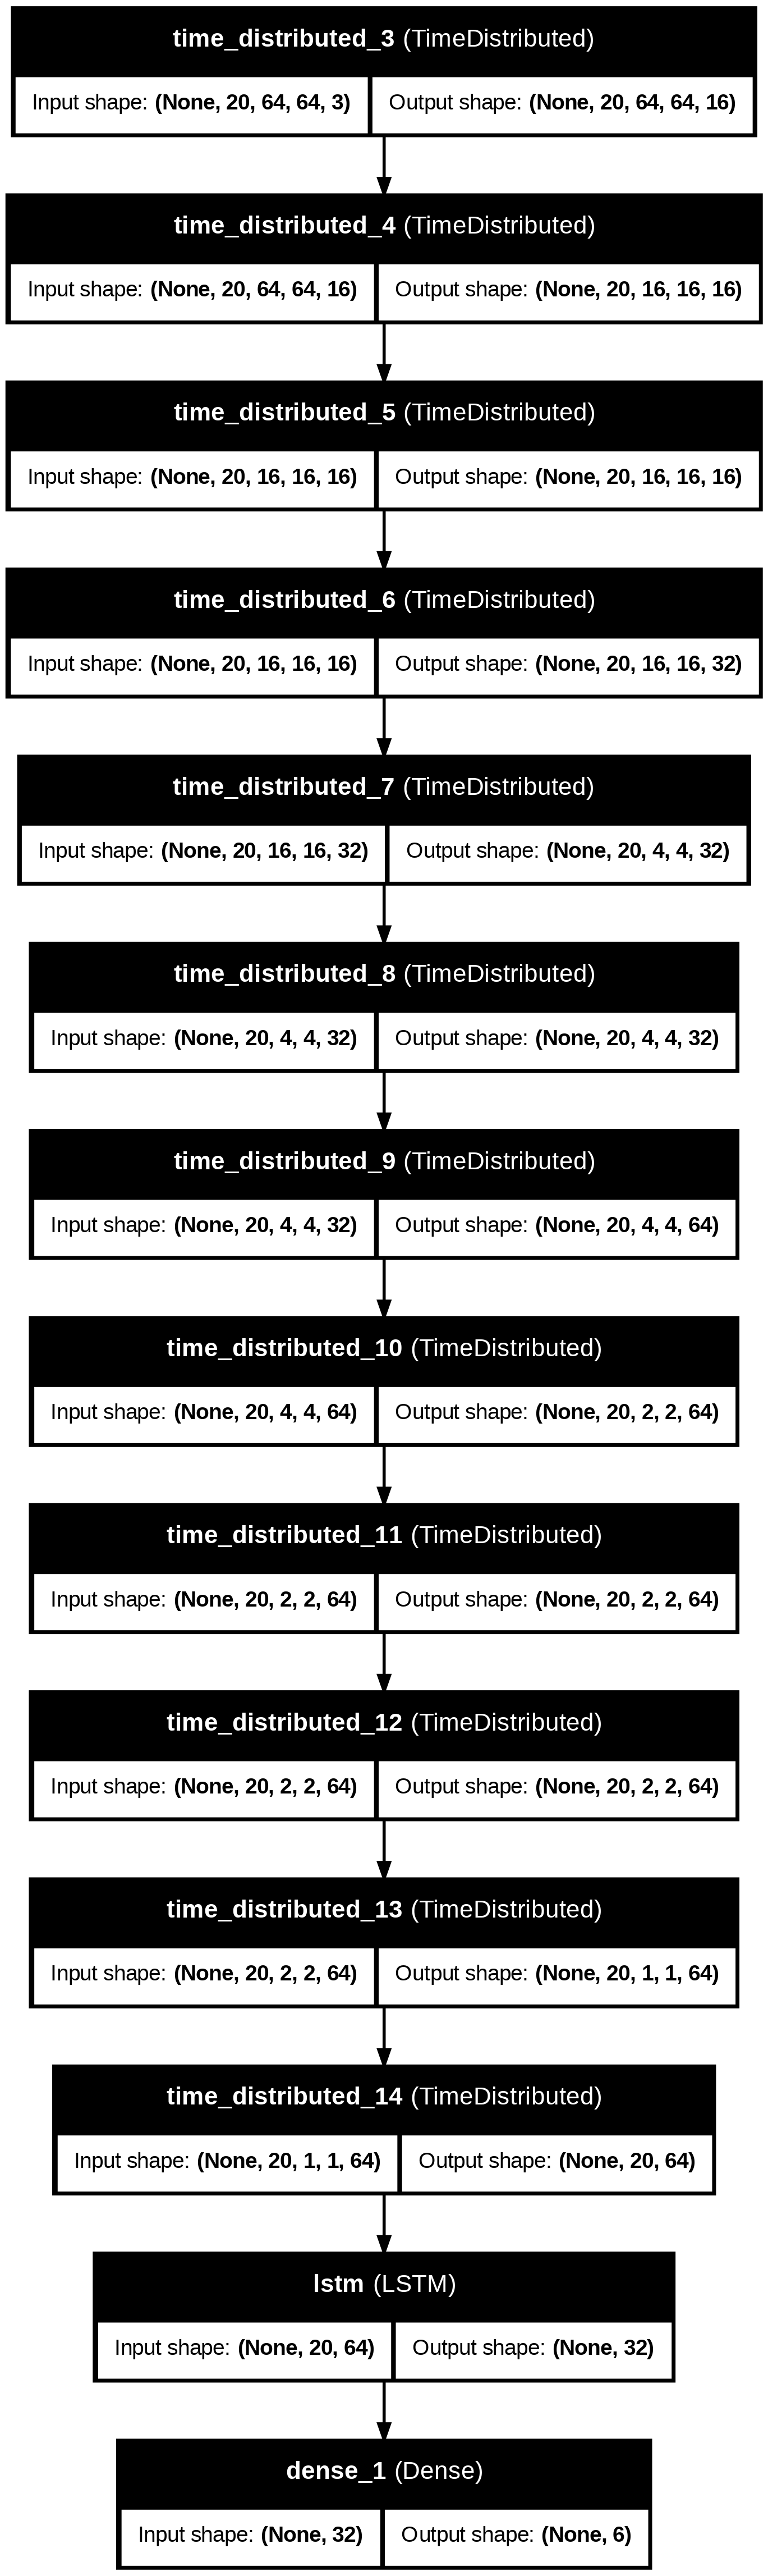

In [ ]:

# Plot the structure of the contructed LRCN model.
plot_model(LRCN_model, to_file = 'LRCN_model_structure_plot.png', show_shapes = True, show_layer_names = True)

In [ ]:
# Create an Instance of Early Stopping Callback.
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 15, mode = 'min', restore_best_weights = True)

# Compile the model and specify loss function, optimizer and metrics to the model.
LRCN_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

# Start training the model.
LRCN_model_training_history = LRCN_model.fit(x = features_train, y = labels_train, epochs = 20, batch_size = 4 , shuffle = True, validation_split = 0.2, callbacks = [early_stopping_callback])

Epoch 1/20
116/116 ━━━━━━━━━━━━━━━━━━━━ 84s 545ms/step - accuracy: 0.2057 - loss: 1.8104 - val_accuracy: 0.0948 - val_loss: 1.7900
Epoch 2/20
116/116 ━━━━━━━━━━━━━━━━━━━━ 78s 515ms/step - accuracy: 0.2654 - loss: 1.7759 - val_accuracy: 0.1983 - val_loss: 1.7794
Epoch 3/20
116/116 ━━━━━━━━━━━━━━━━━━━━ 83s 531ms/step - accuracy: 0.3591 - loss: 1.7044 - val_accuracy: 0.4224 - val_loss: 1.5001
Epoch 4/20
116/116 ━━━━━━━━━━━━━━━━━━━━ 60s 518ms/step - accuracy: 0.4530 - loss: 1.4649 - val_accuracy: 0.3534 - val_loss: 1.4663
Epoch 5/20
116/116 ━━━━━━━━━━━━━━━━━━━━ 83s 524ms/step - accuracy: 0.5136 - loss: 1.2996 - val_accuracy: 0.4483 - val_loss: 1.3165
Epoch 6/20
116/116 ━━━━━━━━━━━━━━━━━━━━ 81s 515ms/step - accuracy: 0.5274 - loss: 1.2104 - val_accuracy: 0.6207 - val_loss: 1.1093
Epoch 7/20
116/116 ━━━━━━━━━━━━━━━━━━━━ 82s 516ms/step - accuracy: 0.5742 - loss: 1.0896 - val_accuracy: 0.7328 - val_loss: 0.8834
Epoch 8/20
116/116 ━━━━━━━━━━━━━━━━━━━━ 85s 544ms/step - accuracy: 0.6409 - loss: 0

In [ ]:
# Evaluate the trained model.
model_evaluation_history = LRCN_model.evaluate(features_test, labels_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 582ms/step - accuracy: 0.8521 - loss: 0.4745


In [ ]:
# Get the loss and accuracy from model_evaluation_history.
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history

# Define the string date format.
# Get the current Date and Time in a DateTime Object.
# Convert the DateTime object to string according to the style mentioned in date_time_format string.
date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)

# Define a useful name for our model to make it easy for us while navigating through multiple saved models.
model_file_name = f'LRCN_model___Date_Time_{current_date_time_string}___Loss_{model_evaluation_loss}___Accuracy_{model_evaluation_accuracy}.h5'

# Save the Model.
LRCN_model.save(model_file_name)

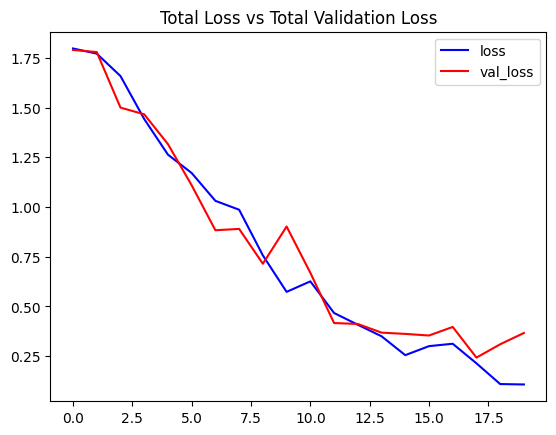

In [ ]:
# Visualize the training and validation loss metrices.
plot_metric(LRCN_model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

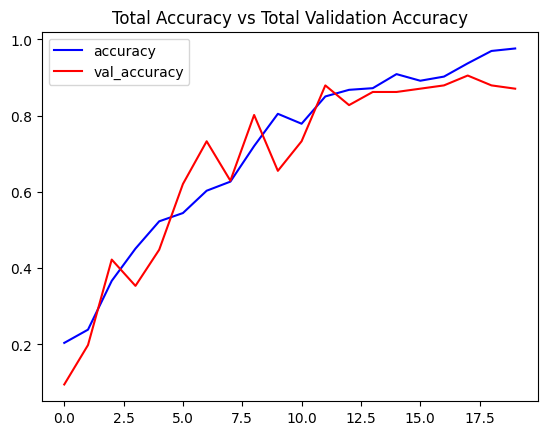

In [ ]:
# Visualize the training and validation accuracy metrices.
plot_metric(LRCN_model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')

In [ ]:
def download_youtube_videos(youtube_video_url, output_directory):
     '''
    This function downloads the youtube video whose URL is passed to it as an argument.
    Args:
        youtube_video_url: URL of the video that is required to be downloaded.
        output_directory:  The directory path to which the video needs to be stored after downloading.
    Returns:
        title: The title of the downloaded youtube video.
    '''

     # Create a video object which contains useful information about the video.
     video = pafy.new(youtube_video_url)

     # Retrieve the title of the video.
     title = video.title

     # Get the best available quality object for the video.
     video_best = video.getbest()

     # Construct the output file path.
     output_file_path = f'{output_directory}/{title}.mp4'

     # Download the youtube video at the best available quality and store it to the contructed path.
     video_best.download(filepath = output_file_path, quiet = True)

     # Return the video title.
     return title

In [ ]:
!pip install --upgrade youtube-dl

In [ ]:
import os
import cv2
import pafy
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt

from moviepy.editor import *
%matplotlib inline

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

def download_youtube_videos(youtube_video_url, output_directory):
    """
    This function downloads the youtube video whose URL is passed to it as an argument.
    Args:
        youtube_video_url: URL of the video that is required to be downloaded.
        output_directory:  The directory path to which the video needs to be stored after downloading.
    Returns:
        title: The title of the downloaded youtube video.
    """

    try:
        # Use youtube-dl directly to extract video information
        import youtube_dl

        ydl_opts = {'outtmpl': os.path.join(output_directory, '%(title)s.%(ext)s'),
                    'quiet': True}
        with youtube_dl.YoutubeDL(ydl_opts) as ydl:
            info_dict = ydl.extract_info(youtube_video_url, download=True)
            title = info_dict.get('title', None)

        return title

    except (youtube_dl.utils.DownloadError, OSError) as e:
        print(f"An error occurred while downloading the video: {e}")
        # Handle the error, e.g., skip the video or try a different URL
        return None

In [ ]:
!pip install pytube

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 2.8 MB/s eta 0:00:00


In [ ]:
from pytube import YouTube

def download_youtube_videos(youtube_video_url, output_directory):
    """
    This function downloads the youtube video whose URL is passed to it as an argument.
    Args:
        youtube_video_url: URL of the video that is required to be downloaded.
        output_directory:  The directory path to which the video needs to be stored after downloading.
    Returns:
        title: The title of the downloaded youtube video.
    """

    try:
        yt = YouTube(youtube_video_url)
        stream = yt.streams.filter(progressive=True, file_extension='mp4').order_by('resolution').desc().first()
        title = yt.title
        output_file_path = os.path.join(output_directory, f"{title}.mp4")
        stream.download(output_path=output_directory, filename=title)

        return title

    except Exception as e:
        print(f"An error occurred while downloading the video: {e}")
        return None

In [ ]:
!pip install pytube==12.1.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 kB 2.7 MB/s eta 0:00:00
  Attempting uninstall: pytube
    Found existing installation: pytube 15.0.0
    Uninstalling pytube-15.0.0:
      Successfully uninstalled pytube-15.0.0


In [ ]:

from pytube import YouTube
from pytube import extract
from pytube.cipher import Cipher

def download_youtube_videos(youtube_video_url, output_directory):
    """
    This function downloads the youtube video whose URL is passed to it as an argument.
    Args:
        youtube_video_url: URL of the video that is required to be downloaded.
        output_directory:  The directory path to which the video needs to be stored after downloading.
    Returns:
        title: The title of the downloaded youtube video.
    """
    try:
        yt = YouTube(youtube_video_url)
        js_url = extract.js_url(yt.watch_html)
        js = yt.request.get(js_url)
        cipher = Cipher(js=js)

        # Update the innertube API key with the new key
        yt.js = js
        yt.vid_info['innertubeApiKey'] = extract.innertube_api_key(yt.js)
        yt.cipher = cipher

        stream = yt.streams.filter(progressive=True, file_extension='mp4').order_by('resolution').desc().first()
        title = yt.title
        output_file_path = os.path.join(output_directory, f"{title}.mp4")
        stream.download(output_path=output_directory, filename=title)

        return title

    except Exception as e:
        print(f"An error occurred while downloading the video: {e}")
        return None

In [ ]:
!pip install --upgrade pytube

  Using cached pytube-15.0.0-py3-none-any.whl.metadata (5.0 kB)
Using cached pytube-15.0.0-py3-none-any.whl (57 kB)
  Attempting uninstall: pytube
    Found existing installation: pytube 12.1.0
    Uninstalling pytube-12.1.0:
      Successfully uninstalled pytube-12.1.0


In [ ]:
from pytube import YouTube
from pytube import extract
from pytube.cipher import Cipher
from urllib.request import urlopen

def download_youtube_videos(youtube_video_url, output_directory):
    """
    This function downloads the youtube video whose URL is passed to it as an argument.
    Args:
        youtube_video_url: URL of the video that is required to be downloaded.
        output_directory:  The directory path to which the video needs to be stored after downloading.
    Returns:
        title: The title of the downloaded youtube video.
    """
    try:
        yt = YouTube(youtube_video_url)
        js_url = extract.js_url(yt.watch_html)

        # Use urlopen instead of yt.request
        with urlopen(js_url) as response:
            js = response.read().decode()

        cipher = Cipher(js=js)

        # Update the innertube API key with the new key
        yt.js = js
        yt.vid_info['innertubeApiKey'] = extract.innertube_api_key(yt.js)
        yt.cipher = cipher

        stream = yt.streams.filter(progressive=True, file_extension='mp4').order_by('resolution').desc().first()
        title = yt.title
        output_file_path = os.path.join(output_directory, f"{title}.mp4")
        stream.download(output_path=output_directory, filename=title)

        return title

    except Exception as e:
        print(f"An error occurred while downloading the video: {e}")
        return None


In [ ]:
!pip install yt-dlp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.2/172.2 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 32.1 MB/s eta 0:00:00


In [ ]:
def download_youtube_videos(youtube_video_url, output_directory):
     '''
    This function downloads the youtube video whose URL is passed to it as an argument.
    Args:
        youtube_video_url: URL of the video that is required to be downloaded.
        output_directory:  The directory path to which the video needs to be stored after downloading.
    Returns:
        title: The title of the downloaded youtube video.
    '''

     # Create a video object which contains useful information about the video.
     video = pafy.new(youtube_video_url)

     # Retrieve the title of the video.
     title = video.title

     # Get the best available quality object for the video.
     video_best = video.getbest()

     # Construct the output file path.
     output_file_path = f'{output_directory}/{title}.mp4'

     # Download the youtube video at the best available quality and store it to the contructed path.
     video_best.download(filepath = output_file_path, quiet = True)

     # Return the video title.
     return title

In [ ]:
!pip install yt-dlp

In [ ]:
import os
import cv2
import pafy
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt

from moviepy.editor import *
%matplotlib inline

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

def download_youtube_videos(youtube_video_url, output_directory):
    '''
    This function downloads the youtube video whose URL is passed to it as an argument.
    Args:
        youtube_video_url: URL of the video that is required to be downloaded.
        output_directory:  The directory path to which the video needs to be stored after downloading.
    Returns:
        title: The title of the downloaded youtube video.
    '''

    try:
        # Import the youtube_dl module
        import yt_dlp

        # Set the options for youtube-dl
        ydl_opts = {
            'outtmpl': os.path.join(output_directory, '%(title)s.%(ext)s'),  # Define the output file path and format
            'quiet': True, # Suppress verbose output
        }

        # Create a youtube-dl object
        with yt_dlp.YoutubeDL(ydl_opts) as ydl:
            # Download the video
            info_dict = ydl.extract_info(youtube_video_url, download=True)  # Download=True triggers the download

            # Get the video title
            title = info_dict.get('title', None)
    except (yt_dlp.utils.DownloadError, OSError) as e:
        print(f"An error occurred while downloading the video: {e}")
        # Handle the error, e.g., skip the video or try a different URL
        return None

    return title # Return the video title

In [ ]:
def predict_on_video(video_file_path, output_file_path, SEQUENCE_LENGTH):
    '''
    This function will perform action recognition on a video using the LRCN model.
    Args:
    video_file_path:  The path of the video stored in the disk on which the action recognition is to be performed.
    output_file_path: The path where the ouput video with the predicted action being performed overlayed will be stored.
    SEQUENCE_LENGTH:  The fixed number of frames of a video that can be passed to the model as one sequence.
    '''

    # Initialize the VideoCapture object to read from the video file.
    video_reader = cv2.VideoCapture(video_file_path)

    # Get the width and height of the video.
    original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Initialize the VideoWriter Object to store the output video in the disk.
    video_writer = cv2.VideoWriter(output_file_path, cv2.VideoWriter_fourcc('M', 'P', '4', 'V'),
                                   video_reader.get(cv2.CAP_PROP_FPS), (original_video_width, original_video_height))

    # Declare a queue to store video frames.
    frames_queue = deque(maxlen = SEQUENCE_LENGTH)

    # Initialize a variable to store the predicted action being performed in the video.
    predicted_class_name = ''

    # Iterate until the video is accessed successfully.
    while video_reader.isOpened():

        # Read the frame.
        ok, frame = video_reader.read()

        # Check if frame is not read properly then break the loop.
        if not ok:
            break

        # Resize the Frame to fixed Dimensions.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))

        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1.
        normalized_frame = resized_frame / 255

        # Appending the pre-processed frame into the frames list.
        frames_queue.append(normalized_frame)

        # Check if the number of frames in the queue are equal to the fixed sequence length.
        if len(frames_queue) == SEQUENCE_LENGTH:

            # Pass the normalized frames to the model and get the predicted probabilities.
            predicted_labels_probabilities = LRCN_model.predict(np.expand_dims(frames_queue, axis = 0))[0]

            # Get the index of class with highest probability.
            predicted_label = np.argmax(predicted_labels_probabilities)

            # Get the class name using the retrieved index.
            predicted_class_name = CLASSES_LIST[predicted_label]

        # Write predicted class name on top of the frame.
        cv2.putText(frame, predicted_class_name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

        # Write The frame into the disk using the VideoWriter Object.
        video_writer.write(frame)

    # Release the VideoCapture and VideoWriter objects.
    video_reader.release()
    video_writer.release()

In [ ]:
def predict_single_action(video_file_path, SEQUENCE_LENGTH):
    '''
    This function will perform single action recognition prediction on a video using the LRCN model.
    Args:
    video_file_path:  The path of the video stored in the disk on which the action recognition is to be performed.
    SEQUENCE_LENGTH:  The fixed number of frames of a video that can be passed to the model as one sequence.
    '''

    # Initialize the VideoCapture object to read from the video file.
    video_reader = cv2.VideoCapture(video_file_path)

    # Get the width and height of the video.
    original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Declare a list to store video frames we will extract.
    frames_list = []

    # Initialize a variable to store the predicted action being performed in the video.
    predicted_class_name = ''

    # Get the number of frames in the video.
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    # Calculate the interval after which frames will be added to the list.
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH),1)

    # Iterating the number of times equal to the fixed length of sequence.
    for frame_counter in range(SEQUENCE_LENGTH):

        # Set the current frame position of the video.
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

        # Read a frame.
        success, frame = video_reader.read()

        # Check if frame is not read properly then break the loop.
        if not success:
            break

        # Resize the Frame to fixed Dimensions.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))

        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1.
        normalized_frame = resized_frame / 255

        # Appending the pre-processed frame into the frames list
        frames_list.append(normalized_frame)

    # Check if frames_list has enough frames
    if len(frames_list) < SEQUENCE_LENGTH:
        print(f"Video is too short. It has {len(frames_list)} frames, but {SEQUENCE_LENGTH} are required.")
        # Pad the frames_list with the last frame to reach SEQUENCE_LENGTH
        last_frame = frames_list[-1]
        frames_list.extend([last_frame] * (SEQUENCE_LENGTH - len(frames_list)))

    # Passing the pre-processed frames to the model and get the predicted probabilities.
    predicted_labels_probabilities = LRCN_model.predict(np.expand_dims(frames_list, axis=0))[0]

    # Get the index of class with highest probability.
    predicted_label = np.argmax(predicted_labels_probabilities)

    # Get the class name using the retrieved index.
    predicted_class_name = CLASSES_LIST[predicted_label]

    # Release the VideoCapture object.
    video_reader.release()

    # Return the predicted class name and confidence
    return predicted_class_name, predicted_labels_probabilities[predicted_label]

In [ ]:
def predict_single_action(video_file_path, SEQUENCE_LENGTH):
    frames_list = []

    cap = cv2.VideoCapture(video_file_path)
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        resized_frame = cv2.resize(frame, IMAGE_SIZE)
        normalized_frame = resized_frame / 255.0
        frames_list.append(normalized_frame)
    cap.release()

    # If no frames were read, return an error message
    if len(frames_list) == 0:
        print("❌ Error: No frames found in the video. Please check the file path or video content.")
        return "Unknown", 0.0

    if len(frames_list) < SEQUENCE_LENGTH:
        print(f"⚠️ Video is too short. It has {len(frames_list)} frames, but {SEQUENCE_LENGTH} are required.")
        last_frame = frames_list[-1]
        frames_list.extend([last_frame] * (SEQUENCE_LENGTH - len(frames_list)))

    frames = np.array(frames_list[:SEQUENCE_LENGTH])
    predicted_label_probabilities = model.predict(np.expand_dims(frames, axis=0))[0]

    predicted_label_index = np.argmax(predicted_label_probabilities)
    predicted_class_name = label_encoder.inverse_transform([predicted_label_index])[0]
    confidence = predicted_label_probabilities[predicted_label_index]

    return predicted_class_name, confidence


In [ ]:
import os
print(os.listdir('/content'))


['.config', 'UCF50', 'UCF50.rar', 'LRCN_model_structure_plot.png', 'LRCN_model___Date_Time_2025_04_14__18_36_55___Loss_0.4106690287590027___Accuracy_0.8704662919044495.h5', 'convlstm_model_structure_plot.png', 'convlstm_model___Date_Time_2025_04_14__18_10_06___Loss_0.4880639910697937___Accuracy_0.8393782377243042.h5', 'sample_data']


In [ ]:
from tensorflow.keras.models import load_model
model = load_model('LRCN_model___Date_Time_2025_04_14__18_36_55___Loss_0.4106690287590027___Accuracy_0.8704662919044495.h5')

In [ ]:

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
import os

video_path = '/content/UCF50/WalkingWithDog/v_WalkingWithDog_g02_c03.avi'  # Adjust path as necessary
if os.path.exists(video_path):
    print(f"Video found: {video_path}")
else:
    print(f"Video not found: {video_path}")


Video found: /content/UCF50/WalkingWithDog/v_WalkingWithDog_g02_c03.avi


In [ ]:
import cv2
import os

video_path = '/content/UCF50/WalkingWithDog/v_WalkingWithDog_g02_c03.avi'  # Adjust the video path

# Check if the file exists
if not os.path.exists(video_path):
    print(f"Error: The file {video_path} does not exist.")
else:
    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        print(f"Error: Couldn't open the video file {video_path}.")
    else:
        print(f"Video file {video_path} opened successfully.")


Video file /content/UCF50/WalkingWithDog/v_WalkingWithDog_g02_c03.avi opened successfully.


In [ ]:
from tensorflow.keras.models import load_model

# Load your trained model (choose one)
model = load_model('LRCN_model___Date_Time_2025_04_14__18_36_55___Loss_0.4106690287590027___Accuracy_0.8704662919044495.h5')



In [ ]:
# Make sure frames_array_reshaped is already defined correctly
predictions = model.predict(frames_array_reshaped)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


In [ ]:
import numpy as np
import cv2

# Load the video file
video_path = '/content/UCF50/TaiChi/v_TaiChi_g02_c01.avi'  # Adjust the video path
cap = cv2.VideoCapture(video_path)

# Initialize the frames list to store processed frames
frames = []

# Read the video frames one by one
while(cap.isOpened()):
    ret, frame = cap.read()
    if not ret:
        break

    # Preprocessing: Resize the frame to (64, 64) and convert it to RGB
    frame_resized = cv2.resize(frame, (64, 64))  # Adjust size as per your model's requirement
    frame_rgb = cv2.cvtColor(frame_resized, cv2.COLOR_BGR2RGB)  # Convert to RGB
    frames.append(frame_rgb)

cap.release()

# Ensure that the number of frames is 20 (adjust if needed)
if len(frames) >= 20:
    frames = frames[:20]  # Take only the first 20 frames if there are more
else:
    print(f"Warning: Not enough frames in the video ({len(frames)} frames).")

# Convert frames list into a NumPy array (or a batch)
frames_array = np.array(frames)

# Normalize the data
frames_array = frames_array / 255.0  # Example normalization

# Reshape to (batch_size, time_steps, height, width, channels)
frames_array_reshaped = np.expand_dims(frames_array, axis=0)  # Add batch dimension

# Make the prediction
predictions = model.predict(frames_array_reshaped)

# Print out the predictions
print("Predictions: ", predictions)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
Predictions:  [[4.5328908e-02 9.3634498e-01 5.8025010e-03 3.0709032e-03 9.2389295e-03
  2.1363355e-04]]


In [ ]:
from tensorflow.keras.models import load_model

# Load the model (adjust the path to where your model is saved)
model = load_model('LRCN_model___Date_Time_2025_04_14__18_36_55___Loss_0.4106690287590027___Accuracy_0.8704662919044495.h5')

# Reshape to (batch_size, time_steps, height, width, channels)
frames_array_reshaped = np.expand_dims(frames_array, axis=0)  # Add batch dimension

# Make the prediction
predictions = model.predict(frames_array_reshaped)

# Print out the predictions
print("Predictions: ", predictions)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predictions:  [[4.5328908e-02 9.3634498e-01 5.8025010e-03 3.0709032e-03 9.2389295e-03
  2.1363355e-04]]


In [ ]:
import numpy as np


# Define the class labels
CLASSES_LIST = ["WalkingWithDog", "TaiChi", "Swing", "HorseRace", "JumpingJack", "PlayingGuitar"]

# Get the index of the highest probability
predicted_class_index = np.argmax(predictions)

# Get the predicted class label
predicted_class_label = CLASSES_LIST[predicted_class_index]

print(f"Predicted class: {predicted_class_label}")


Predicted class: TaiChi
